# C1 - Introduction to Human and Computer Vision
## Week 4

In [99]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week4')
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = '../data'

In [100]:
# Read pickle file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

# Read pickle file with correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w4/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

### a) Remove background, detect noise (and filter it)

In [101]:
from src.background_removal import background_removal
from src.noise_removal import denoise_image
from tqdm import tqdm

# Image names
QSD1_w4_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4/') if f.endswith('.jpg')]
QSD1_w4_names.sort()

# Initialize datasets
BBDD = []
QSD1_w4 = []
QSD1_w4_filtered = []
QSD1_w4_nonAugmented = []

# Load datasets (+ filter)
for image_name in tqdm(QSD1_w4_names):
    # Read QSD1_w4
    image_qsd1 = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/{image_name}')
    QSD1_w4.append(image_qsd1)

    # Read non-augmented image
    image_nonAugmented = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/non_augmented/{image_name}')
    image_nonAug_bckg_remov = background_removal(denoise_image(image_nonAugmented))  # Remove background in non-augmented image
   
    QSD1_w4_nonAugmented.append(image_nonAug_bckg_remov)

    # Filter image from QSD1_w4
    filtered_image = background_removal(denoise_image(image_qsd1))  # Detect noise (and clean it) + Remove background
    if filtered_image == []:
        filtered_image = image_qsd1
    QSD1_w4_filtered.append(filtered_image)


# Read BBDD
BBDD_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/BBDD/') if f.endswith('.jpg')]
BBDD_names.sort()

for image_name in tqdm(BBDD_names):
    image_bbdd = cv2.imread(f'{DATA_DIRECTORY}/BBDD/{image_name}')
    BBDD.append(image_bbdd)

100%|██████████| 287/287 [00:04<00:00, 65.83it/s]


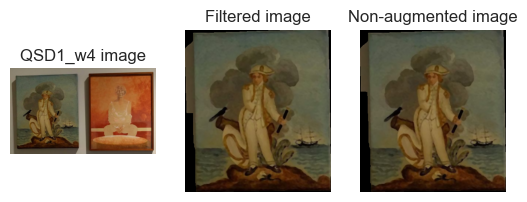

In [104]:
# Plot some examples
img_number = 2


fig, axes = plt.subplots(1, 3)  # 1 fila, 3 columnas

# QSD1_w4 image
image = QSD1_w4[img_number]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].set_title('QSD1_w4 image')
axes[0].axis('Off')

# Filtered image (background removal + denoise)
image = QSD1_w4_filtered[img_number][1]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[1].imshow(image)
axes[1].set_title('Filtered image')
axes[1].axis('Off')

# Non-augmented image
image = QSD1_w4_nonAugmented[img_number][1]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[2].imshow(image)
axes[2].set_title('Non-augmented image')
axes[2].axis('Off')

plt.show()
plt.close()

### b) Detect keypoints and compute descriptors

In [ ]:
'''
flags = {
  DEFAULT = 0,
  DRAW_OVER_OUTIMG = 1,
  NOT_DRAW_SINGLE_POINTS = 2,
  DRAW_RICH_KEYPOINTS = 4
}
'''
def draw_keypoints(image, kp, flags=0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img2 = cv2.drawKeypoints(gray_image, kp, None,(255,0,0),flags=flags)
    plt.imshow(img2) 

#### SIFT

In [ ]:
def sift_descriptor(image, params={}):
    '''
    Compute SIFT descriptors for a given image
    :param image: image to compute the descriptors
    :param params: parameters for the SIFT algorithm
    :return: keypoints and descriptors

    default params = {
        'nfeatures': 0,
        'nOctaveLayers': 3,
        'contrastThreshold': 0.04,
        'edgeThreshold': 10,
        'sigma': 1.6
    }
    '''
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(**params)
    kp, des = sift.detectAndCompute(img_gray, None)

    return (kp, des)

In [ ]:
# Reshape all images to 256x256
QSD1_w4 = [cv2.resize(image, (256, 256)) for image in QSD1_w4]
BBDD = [cv2.resize(image, (256, 256)) for image in BBDD]
# For QSD1_w4_filtered, each element is a list of images
QSD1_w4_filtered = [[cv2.resize(image, (256, 256)) for image in images] for images in QSD1_w4_filtered]

In [ ]:
'''
default params = {
    'nfeatures': 0,
    'nOctaveLayers': 3,
    'contrastThreshold': 0.04,
    'edgeThreshold': 10,
    'sigma': 1.6
}
'''
params = {
    'nfeatures': 1000,
}

sift_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:
        kp, des = sift_descriptor(painting, params=params)
        res.append({'kp': kp, 'des': des})
    sift_query.append(res)


sift_bd = []
for painting in tqdm(BBDD):
    kp, des = sift_descriptor(painting, params=params)
    sift_bd.append({'kp': kp, 'des': des})

100%|██████████| 287/287 [00:04<00:00, 59.71it/s]


In [9]:
idx1 = 6 # Query image
idx2 = ground_truth[6][0] # BBDD image

des1 = sift_query[idx1][0]['des']
des2 = sift_bd[idx2]['des']

### With distances

In [11]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

res = []
dist_res = []
# Matrix of size 30xN where N is the number of images in the BBDD
for i in tqdm(range(30)):
    picture_res = []
    picture_distances = []
    for j in range(0, len(sift_query[i])):
        distances = []
        for k in range(0, len(sift_bd)):
            if sift_bd[k]['des'] is not None:
                matches = bf.match(sift_query[i][j]['des'], sift_bd[k]['des'])
                matches = sorted(matches, key = lambda x:x.distance)
                distance = np.mean([match.distance for match in matches[:20]])
                distances.append(distance)
            else:
                distances.append(10000)

        # Take top 10 matches
        most_similar = np.argsort(distances)[:10]
        most_similar_distances = [distances[idx] for idx in most_similar]
        if most_similar_distances[0] == 10000:
            most_similar = [-1]
            most_similar_distances = [10000]
        if (
            most_similar_distances[1] - most_similar_distances[0] < 
            2*np.mean(np.array(most_similar_distances[2:10]) - np.array(most_similar_distances[1:9]))
        ):
            most_similar = [-1]
        picture_res.append(most_similar)
        picture_distances.append(most_similar_distances)
    
    res.append(picture_res)
    dist_res.append(picture_distances)


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


### With my method

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming `sift_query`, `sift_bd`, and `ground_truth` are defined with the proper structure
dist_res = []
is_not_present = []  # New list to store color based on ground_truth
res = []

# Modify the loop to populate dist_res and colors
for i in tqdm(range(30)):
    picture_distances = []
    picture_most_similar = []
    for j in range(0, len(sift_query[i])):
        distances = []
        for k in range(0, len(sift_bd)):
            if sift_bd[k]['des'] is not None:
                descriptors1 = sift_query[i][j]['des']
                keypoints1 = sift_query[i][j]['kp']
                descriptors2 = sift_bd[k]['des']
                keypoints2 = sift_bd[k]['kp']

                # Use BFMatcher to match descriptors
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
                matches = bf.match(descriptors1, descriptors2)

                # Sort matches by distance and select the top 20 most similar matches
                matches = sorted(matches, key=lambda x: x.distance)[:10]

                if len(matches) < 10:
                    distances.append(10000)
                    continue

                # Extract the matched keypoints' coordinates for the top 10 matches
                matched_points_img1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
                matched_points_img2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

                # Calculate the relative positions in both images
                relative_positions = matched_points_img2 - matched_points_img1

                distances.append(np.mean(np.linalg.norm(relative_positions, axis=1)))
            else:
                distances.append(10000)
            
        # Take top 10 matches
        most_similar_distances = [distances[idx] for idx in np.argsort(distances)[:10]]
        picture_distances.append(most_similar_distances)

        if (most_similar_distances[1] - most_similar_distances[0]) / most_similar_distances[0] < 0.3:
            picture_most_similar.append([-1])
        else:
            picture_most_similar.append(np.argsort(distances)[:10])
        
        # Determine color based on ground_truth[i]
        if ground_truth[i] == [-1]:
            is_not_present.append('Not in BDD')
        else:
            is_not_present.append('In BDD')
    
    dist_res.append(picture_distances)
    res.append(picture_most_similar)

100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


# Jitter plot

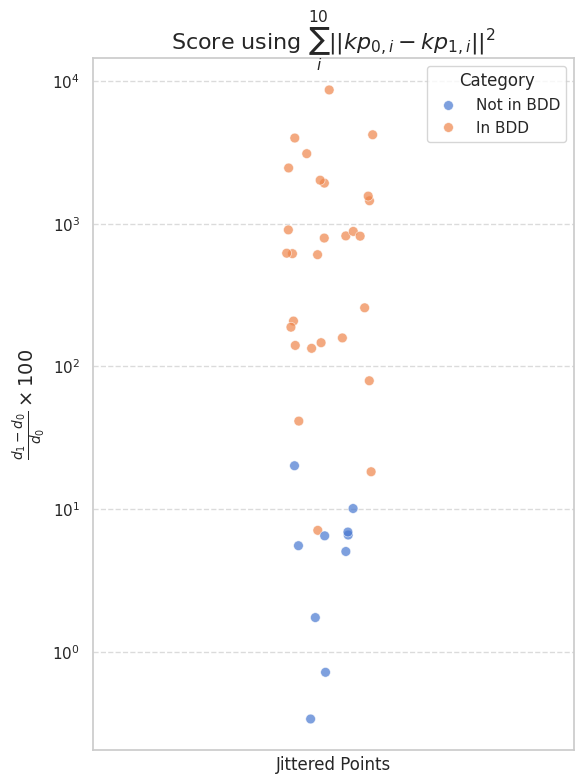

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# Ensure Seaborn's style is applied
sns.set(style="whitegrid", palette="muted")

# Once `dist_res` and `colors` are populated, calculate values for the scatter plot
values = []
for i in range(len(dist_res)):
    for j in range(len(dist_res[i])):
        values.append((dist_res[i][j][1] - dist_res[i][j][0]) / dist_res[i][j][0] * 100)

# Create a DataFrame for better control over the data (optional but useful for seaborn)
import pandas as pd

data = pd.DataFrame({
    'Jittered Points': np.ones(len(values)),  # Place all points at x=1, will jitter automatically
    'Values': values,
    'Category': is_not_present  # Using colors to represent categories (0 or 1)
})

# Plot
plt.figure(figsize=(6, 8))

# Use seaborn's stripplot for jittering
sns.stripplot(x='Jittered Points', y='Values', data=data, jitter=True, hue='Category', 
              dodge=False, alpha=0.7, size=7, edgecolor="w", linewidth=0.5)

# Set the y-axis label with LaTeX formatted formula
plt.ylabel(r'$\frac{d_1-d_0}{d_0} \times 100$', fontsize=14)

plt.title(r'Score using $\sum_i^{10}||kp_{0, i} - kp_{1, i}||^2$', fontsize=16)

# Remove x-ticks for a cleaner look
plt.xticks([])

# Add grid lines for y-axis, with adjusted style
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Apply log scale to y-axis
plt.yscale('log')

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [75]:
import importlib
import src.metrics  # re-import the module to make sure it's recognized
importlib.reload(src.metrics)

from src.metrics import mapk

# Now you can call the updated mapk function
mapk(ground_truth, res, k=1)


-1 [-1]
150 [150 187 124 267 179 175 159  17 214 191]
48 [ 48  15 270  67  20  30  13 135 201 226]
251 [251 153  62  78 196  71  11 203 127  85]
32 [ 32 162 152  53 136  71  55 118 200 232]
161 [161 172   6 185 284 124 163 135  30  33]
81 [ 81  72  15 153 124 250 107 129 191 132]
62 [ 62  30 183  90 214 235 125 270 123 179]
38 [ 38 154  65   2  91  20 244  49  48 209]
-1 [-1]
128 [-1]
155 [155 190  90 207 250 191  62  37 268  86]
258 [258 240 158 219  17 164  75  35  67   4]
136 [136 166   7 198 185 274  30 255  71 269]
76 [ 76 155  56  20  57  15 272 211 175  90]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [ 12 124  46 111 200 179 135  20 282 114]
11 [-1]
280 [280   4 243 284 151 191 118 250  30  61]
-1 [-1]
182 [182  74 240 136 280 270  41   9 165 194]
252 [252  52  22 107  30 129 221 250 155  92]
-1 [-1]
272 [272 151  20  90 243 185  81 224  71 219]
117 [117  30  71 171  66 134  53 129 219 207]
-1 [-1]
242 [242 267 214 179 124 220  37  42 169   8]
260 [260 284 207 124 170 213 199  46  30  90

np.float64(0.9230769230769231)

### To print correspondences between two images

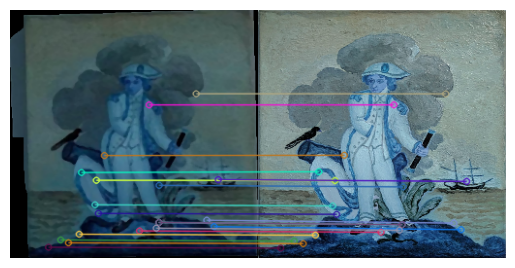

Distance: 77.36103248596191
7.8590355


In [97]:
import cv2
import numpy as np

i, j, k = 2, 0, ground_truth[2][0]

descriptors1 = sift_query[i][j]['des']
keypoints1 = sift_query[i][j]['kp']
descriptors2 = sift_bd[k]['des']
keypoints2 = sift_bd[k]['kp']

# Use BFMatcher to match descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance and select the top 10 most similar matches
matches = sorted(matches, key=lambda x: x.distance)[:20]

# Extract the matched keypoints' coordinates for the top 10 matches
matched_points_img1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
matched_points_img2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Calculate the relative positions in both images
relative_positions = matched_points_img2 - matched_points_img1

img3 = cv2.drawMatches(
    QSD1_w4_filtered[i][j], sift_query[i][j]['kp'],
    BBDD[k], sift_bd[k]['kp'],
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.imshow(img3), plt.axis('off'), plt.show()

print('Distance:', np.mean([m.distance for m in matches]))
print(np.mean(np.linalg.norm(relative_positions, axis=1)))

#### HOG

In [19]:
from skimage.feature import hog
from skimage import exposure
from scipy.spatial.distance import euclidean
import importlib

import src.metrics 
importlib.reload(src.metrics)
from src.metrics import mapk

params={
    'shape': (100,100),  # Shape we want to resize the image to
    'pixels_per_cell': (17,17),
    'cells_per_block': (3,3),
}

def hog_descriptor(image, shape: tuple, pixels_per_cell: tuple, cells_per_block: tuple):
    
    # Image to grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize image (we need same dimensions in all the image descriptros to compare)
    image = cv2.resize(image, shape, interpolation=cv2.INTER_AREA)

    # Compute HOG
    hog_descriptor, hog_image = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    
    # Rescale intensity, otherwise we may see everyhing black
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, np.max(hog_image)/10))

    return hog_descriptor, hog_image

def compute_results_hog(hog_query, hog_bd, n: int, threshold: float):
    res = []
    distances_res = []

    for i in tqdm(range(30)):
        picture_res = []
        picture_distances = []
        
        # Para cada pintura dentro de una imagen de hog_query[i]
        for j in range(len(hog_query[i])):
            distances = []

            query_descriptor = hog_query[i][j]['descriptor']
            for p in range(len(hog_bd)): 
                bd_descriptor = hog_bd[p]['descriptor']
                distance = euclidean(query_descriptor, bd_descriptor)
                distances.append((distance, p))

            distances.sort(key=lambda x: x[0])

            # Extraemos los índices y distancias de los k vecinos más cercanos
            nearest_neighbors = [idx for _, idx in distances[:n]] 
            nearest_distances = [dist for dist, _ in distances[:n]]

            # Calculamos la desviación estándar de las distancias
            std_dev = np.std(nearest_distances)
            
            # Si la desviación estándar es menor que el umbral, asignamos [-1] como índice
            if std_dev < threshold:
                nearest_neighbors = [-1]
                nearest_distances = [None] * n  # O [0] o [-1], dependiendo de tu preferencia

            # Añadimos los resultados a las listas finales
            picture_res.append(nearest_neighbors)
            picture_distances.append(nearest_distances)

        res.append(picture_res)
        distances_res.append(picture_distances)

    return res, distances_res


In [15]:
# Take HOG descriptor from Query and BBDD images

hog_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:    
        des, image = hog_descriptor(painting, **params)
        res.append({'descriptor': des, 'image': image})
    hog_query.append(res)

hog_bd = []
for painting in tqdm(BBDD):    
    des, image = hog_descriptor(painting, **params)
    hog_bd.append({'descriptor': des, 'image': image})



100%|██████████| 287/287 [00:04<00:00, 71.49it/s]


In [ ]:
# Compute results
res, distances_res = compute_results_hog(hog_query, hog_bd, n=2, threshold=0.1)

# Mostrar los resultados

print(ground_truth)
print(res)

mapk(ground_truth, res, k=1)

In [22]:
import itertools
from tqdm import tqdm
import cv2
import numpy as np

# Definir combinaciones de parámetros
shapes = [(100, 100)]
pixels_per_cells = [(17, 17)]
cells_per_blocks = [(3,3), (2,2)]
thresholds = [0.9, 0.95, 0.1, 0.105, 0.11, 0.115, 0.12]
n_s = [2,3, 4, 5, 6, 7]

# Inicializar lista de resultados
resultados = []

# Bucle para probar todas las combinaciones de parámetros
for shape, pixels_per_cell, cells_per_block, threshold, n in itertools.product(shapes, pixels_per_cells, cells_per_blocks, thresholds, n_s):
    try:
        # Configuración de parámetros actuales
        params = {
            'shape': shape,
            'pixels_per_cell': pixels_per_cell,
            'cells_per_block': cells_per_block,
        }

        hog_query = []
        for picture in tqdm(QSD1_w4_filtered):
            res = []
            for painting in picture:    
                des, image = hog_descriptor(painting, **params)
                res.append({'descriptor': des, 'image': image})
            hog_query.append(res)

        hog_bd = []
        for painting in tqdm(BBDD):    
            des, image = hog_descriptor(painting, **params)
            hog_bd.append({'descriptor': des, 'image': image})

        # Calcular los resultados de similitud usando HOG con el threshold y k_ actuales
        res, distances_res = compute_results_hog(hog_query, hog_bd, n=n, threshold=threshold)
        score = mapk(ground_truth, res, k=1)  # Calcula la puntuación para esta combinación

        # Guardar la combinación y su puntaje
        resultados.append((params, threshold, n, score))

    except ValueError as e:
        print(f"Combinación inválida {params} con threshold {threshold} y n {n} debido a error: {e}")
        continue  # Pasar a la siguiente combinación en caso de error

# Ordenar los resultados por puntaje (de mayor a menor)
resultados.sort(key=lambda x: x[3], reverse=True)

# Guardar los mejores resultados en un archivo
with open("mejores_resultados.txt", "w") as f:
    for params, threshold, n, score in resultados:
        f.write(f"Parámetros: {params}, Threshold: {threshold}, n: {n}, Score: {score}\n")

print("Búsqueda de parámetros completada. Resultados guardados en 'mejores_resultados.txt'.")

100%|██████████| 30/30 [00:00<00:00, 754.70it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 838.39it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 792.17it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 745.64it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 758.42it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 793.94it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 827.73it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 738.53it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 821.40it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 807.08it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 787.01it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 796.62it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 822.24it/s]


-1 [-1]
150 [150, 95]
48 [48, 57]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 64]
38 [38, 102]
-1 [-1]
128 [128, 113]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 249]
-1 [-1]
-1 [-1]
53 [53, 55]
-1 [-1]
12 [12, 25]
11 [11, 24]
280 [280, 58]
-1 [-1]
182 [182, 233]
252 [-1]
-1 [-1]
272 [272, 154]
117 [117, 88]
-1 [-1]
242 [242, 248]
260 [260, 271]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 802.06it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 57, 106]
251 [251, 255, 40]
32 [32, 259, 88]
161 [161, 40, 163]
81 [81, 205, 241]
62 [62, 64, 197]
38 [38, 102, 101]
-1 [-1]
128 [128, 113, 99]
155 [155, 205, 119]
258 [258, 223, 60]
136 [136, 37, 133]
76 [76, 249, 43]
-1 [-1]
-1 [-1]
53 [53, 55, 254]
-1 [-1]
12 [12, 25, 221]
11 [11, 24, 255]
280 [280, 58, 273]
-1 [-1]
182 [182, 233, 174]
252 [-1]
-1 [-1]
272 [272, 154, 57]
117 [117, 88, 233]
-1 [-1]
242 [242, 248, 176]
260 [260, 271, 32]
94 [94, 225, 40]
132 [132, 137, 57]
223 [223, 174, 58]
-1 [-1]
127 [127, 241, 40]
47 [47, 13, 100]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 814.80it/s]


-1 [-1]
150 [150, 95, 163, 142]
48 [48, 57, 106, 205]
251 [251, 255, 40, 57]
32 [32, 259, 88, 109]
161 [161, 40, 163, 205]
81 [81, 205, 241, 93]
62 [62, 64, 197, 129]
38 [38, 102, 101, 218]
-1 [-1]
128 [128, 113, 99, 241]
155 [155, 205, 119, 217]
258 [258, 223, 60, 57]
136 [136, 37, 133, 161]
76 [76, 249, 43, 142]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54]
-1 [-1]
12 [12, 25, 221, 105]
11 [11, 24, 255, 248]
280 [280, 58, 273, 274]
-1 [26, 165, 169, 166]
182 [182, 233, 174, 133]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81]
117 [117, 88, 233, 60]
-1 [-1]
242 [242, 248, 176, 221]
260 [260, 271, 32, 37]
94 [94, 225, 40, 215]
132 [132, 137, 57, 104]
223 [223, 174, 58, 40]
-1 [78, 221, 93, 74]
127 [127, 241, 40, 205]
47 [47, 13, 100, 52]
13 [13, 47, 52, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 804.29it/s]


-1 [-1]
150 [150, 95, 163, 142, 226]
48 [48, 57, 106, 205, 212]
251 [251, 255, 40, 57, 174]
32 [32, 259, 88, 109, 248]
161 [161, 40, 163, 205, 104]
81 [81, 205, 241, 93, 154]
62 [62, 64, 197, 129, 16]
38 [38, 102, 101, 218, 67]
-1 [-1]
128 [128, 113, 99, 241, 176]
155 [155, 205, 119, 217, 40]
258 [258, 223, 60, 57, 286]
136 [136, 37, 133, 161, 163]
76 [76, 249, 43, 142, 143]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129]
-1 [-1]
12 [12, 25, 221, 105, 93]
11 [11, 24, 255, 248, 215]
280 [280, 58, 273, 274, 160]
-1 [26, 165, 169, 166, 80]
182 [182, 233, 174, 133, 29]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252]
117 [117, 88, 233, 60, 119]
-1 [-1]
242 [242, 248, 176, 221, 107]
260 [260, 271, 32, 37, 29]
94 [94, 225, 40, 215, 248]
132 [132, 137, 57, 104, 103]
223 [223, 174, 58, 40, 60]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 40, 205, 57]
47 [47, 13, 100, 52, 102]
13 [13, 47, 52, 100, 102]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 814.64it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106]
48 [48, 57, 106, 205, 212, 163]
251 [251, 255, 40, 57, 174, 215]
32 [32, 259, 88, 109, 248, 82]
161 [161, 40, 163, 205, 104, 57]
81 [81, 205, 241, 93, 154, 16]
62 [62, 64, 197, 129, 16, 273]
38 [38, 102, 101, 218, 67, 100]
-1 [-1]
128 [128, 113, 99, 241, 176, 8]
155 [155, 205, 119, 217, 40, 64]
258 [258, 223, 60, 57, 286, 119]
136 [136, 37, 133, 161, 163, 174]
76 [76, 249, 43, 142, 143, 16]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198]
-1 [-1]
12 [12, 25, 221, 105, 93, 176]
11 [11, 24, 255, 248, 215, 282]
280 [280, 58, 273, 274, 160, 223]
-1 [26, 165, 169, 166, 80, 5]
182 [182, 233, 174, 133, 29, 137]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281]
117 [117, 88, 233, 60, 119, 205]
-1 [-1]
242 [242, 248, 176, 221, 107, 74]
260 [260, 271, 32, 37, 29, 40]
94 [94, 225, 40, 215, 248, 261]
132 [132, 137, 57, 104, 103, 29]
223 [223, 174, 58, 40, 60, 218]
-1 [78, 221, 93, 74, 156, 202]
127 [127, 241, 40, 205, 57, 93]
47 [47, 13, 100, 52, 102, 192]
1

100%|██████████| 30/30 [00:00<00:00, 681.83it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106, 203]
48 [48, 57, 106, 205, 212, 163, 246]
251 [251, 255, 40, 57, 174, 215, 51]
32 [32, 259, 88, 109, 248, 82, 40]
161 [161, 40, 163, 205, 104, 57, 215]
81 [81, 205, 241, 93, 154, 16, 119]
62 [62, 64, 197, 129, 16, 273, 30]
38 [38, 102, 101, 218, 67, 100, 264]
-1 [264, 186, 45, 24, 11, 101, 206]
128 [128, 113, 99, 241, 176, 8, 14]
155 [155, 205, 119, 217, 40, 64, 65]
258 [258, 223, 60, 57, 286, 119, 163]
136 [136, 37, 133, 161, 163, 174, 137]
76 [76, 249, 43, 142, 143, 16, 95]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198, 19]
-1 [-1]
12 [12, 25, 221, 105, 93, 176, 21]
11 [11, 24, 255, 248, 215, 282, 36]
280 [280, 58, 273, 274, 160, 223, 96]
-1 [26, 165, 169, 166, 80, 5, 66]
182 [182, 233, 174, 133, 29, 137, 255]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281, 40]
117 [117, 88, 233, 60, 119, 205, 104]
-1 [-1]
242 [242, 248, 176, 221, 107, 74, 142]
260 [260, 271, 32, 37, 29, 40, 174]
94 [94, 225, 40, 215, 248, 261, 234]
132 [132, 137, 57, 104, 

100%|██████████| 30/30 [00:00<00:00, 805.37it/s]


-1 [-1]
150 [150, 95]
48 [48, 57]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 64]
38 [38, 102]
-1 [-1]
128 [128, 113]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 249]
-1 [-1]
-1 [-1]
53 [53, 55]
-1 [-1]
12 [12, 25]
11 [11, 24]
280 [280, 58]
-1 [-1]
182 [182, 233]
252 [-1]
-1 [-1]
272 [272, 154]
117 [117, 88]
-1 [-1]
242 [242, 248]
260 [260, 271]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 816.50it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 57, 106]
251 [251, 255, 40]
32 [32, 259, 88]
161 [161, 40, 163]
81 [81, 205, 241]
62 [62, 64, 197]
38 [38, 102, 101]
-1 [-1]
128 [128, 113, 99]
155 [155, 205, 119]
258 [258, 223, 60]
136 [136, 37, 133]
76 [76, 249, 43]
-1 [-1]
-1 [-1]
53 [53, 55, 254]
-1 [-1]
12 [12, 25, 221]
11 [11, 24, 255]
280 [280, 58, 273]
-1 [-1]
182 [182, 233, 174]
252 [-1]
-1 [-1]
272 [272, 154, 57]
117 [117, 88, 233]
-1 [-1]
242 [242, 248, 176]
260 [260, 271, 32]
94 [94, 225, 40]
132 [132, 137, 57]
223 [223, 174, 58]
-1 [-1]
127 [127, 241, 40]
47 [47, 13, 100]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 642.85it/s]


-1 [-1]
150 [150, 95, 163, 142]
48 [48, 57, 106, 205]
251 [251, 255, 40, 57]
32 [32, 259, 88, 109]
161 [161, 40, 163, 205]
81 [81, 205, 241, 93]
62 [62, 64, 197, 129]
38 [38, 102, 101, 218]
-1 [-1]
128 [128, 113, 99, 241]
155 [155, 205, 119, 217]
258 [258, 223, 60, 57]
136 [136, 37, 133, 161]
76 [76, 249, 43, 142]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54]
-1 [-1]
12 [12, 25, 221, 105]
11 [11, 24, 255, 248]
280 [280, 58, 273, 274]
-1 [26, 165, 169, 166]
182 [182, 233, 174, 133]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81]
117 [117, 88, 233, 60]
-1 [-1]
242 [242, 248, 176, 221]
260 [260, 271, 32, 37]
94 [94, 225, 40, 215]
132 [132, 137, 57, 104]
223 [223, 174, 58, 40]
-1 [-1]
127 [127, 241, 40, 205]
47 [47, 13, 100, 52]
13 [13, 47, 52, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 813.95it/s]


-1 [-1]
150 [150, 95, 163, 142, 226]
48 [48, 57, 106, 205, 212]
251 [251, 255, 40, 57, 174]
32 [32, 259, 88, 109, 248]
161 [161, 40, 163, 205, 104]
81 [81, 205, 241, 93, 154]
62 [62, 64, 197, 129, 16]
38 [38, 102, 101, 218, 67]
-1 [-1]
128 [128, 113, 99, 241, 176]
155 [155, 205, 119, 217, 40]
258 [258, 223, 60, 57, 286]
136 [136, 37, 133, 161, 163]
76 [76, 249, 43, 142, 143]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129]
-1 [-1]
12 [12, 25, 221, 105, 93]
11 [11, 24, 255, 248, 215]
280 [280, 58, 273, 274, 160]
-1 [26, 165, 169, 166, 80]
182 [182, 233, 174, 133, 29]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252]
117 [117, 88, 233, 60, 119]
-1 [-1]
242 [242, 248, 176, 221, 107]
260 [260, 271, 32, 37, 29]
94 [94, 225, 40, 215, 248]
132 [132, 137, 57, 104, 103]
223 [223, 174, 58, 40, 60]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 40, 205, 57]
47 [47, 13, 100, 52, 102]
13 [13, 47, 52, 100, 102]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 806.37it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106]
48 [48, 57, 106, 205, 212, 163]
251 [251, 255, 40, 57, 174, 215]
32 [32, 259, 88, 109, 248, 82]
161 [161, 40, 163, 205, 104, 57]
81 [81, 205, 241, 93, 154, 16]
62 [62, 64, 197, 129, 16, 273]
38 [38, 102, 101, 218, 67, 100]
-1 [-1]
128 [128, 113, 99, 241, 176, 8]
155 [155, 205, 119, 217, 40, 64]
258 [258, 223, 60, 57, 286, 119]
136 [136, 37, 133, 161, 163, 174]
76 [76, 249, 43, 142, 143, 16]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198]
-1 [-1]
12 [12, 25, 221, 105, 93, 176]
11 [11, 24, 255, 248, 215, 282]
280 [280, 58, 273, 274, 160, 223]
-1 [26, 165, 169, 166, 80, 5]
182 [182, 233, 174, 133, 29, 137]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281]
117 [117, 88, 233, 60, 119, 205]
-1 [-1]
242 [242, 248, 176, 221, 107, 74]
260 [260, 271, 32, 37, 29, 40]
94 [94, 225, 40, 215, 248, 261]
132 [132, 137, 57, 104, 103, 29]
223 [223, 174, 58, 40, 60, 218]
-1 [78, 221, 93, 74, 156, 202]
127 [127, 241, 40, 205, 57, 93]
47 [47, 13, 100, 52, 102, 192]
1

100%|██████████| 30/30 [00:00<00:00, 820.05it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106, 203]
48 [48, 57, 106, 205, 212, 163, 246]
251 [251, 255, 40, 57, 174, 215, 51]
32 [32, 259, 88, 109, 248, 82, 40]
161 [161, 40, 163, 205, 104, 57, 215]
81 [81, 205, 241, 93, 154, 16, 119]
62 [62, 64, 197, 129, 16, 273, 30]
38 [38, 102, 101, 218, 67, 100, 264]
-1 [-1]
128 [128, 113, 99, 241, 176, 8, 14]
155 [155, 205, 119, 217, 40, 64, 65]
258 [258, 223, 60, 57, 286, 119, 163]
136 [136, 37, 133, 161, 163, 174, 137]
76 [76, 249, 43, 142, 143, 16, 95]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198, 19]
-1 [-1]
12 [12, 25, 221, 105, 93, 176, 21]
11 [11, 24, 255, 248, 215, 282, 36]
280 [280, 58, 273, 274, 160, 223, 96]
-1 [26, 165, 169, 166, 80, 5, 66]
182 [182, 233, 174, 133, 29, 137, 255]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281, 40]
117 [117, 88, 233, 60, 119, 205, 104]
-1 [-1]
242 [242, 248, 176, 221, 107, 74, 142]
260 [260, 271, 32, 37, 29, 40, 174]
94 [94, 225, 40, 215, 248, 261, 234]
132 [132, 137, 57, 104, 103, 29, 163]
223 [223, 174,

100%|██████████| 30/30 [00:00<00:00, 753.39it/s]


-1 [-1]
150 [150, 95]
48 [48, 57]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [-1]
38 [38, 102]
-1 [-1]
128 [128, 113]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 249]
-1 [-1]
-1 [-1]
53 [53, 55]
-1 [-1]
12 [12, 25]
11 [11, 24]
280 [280, 58]
-1 [-1]
182 [182, 233]
252 [-1]
-1 [-1]
272 [272, 154]
117 [117, 88]
-1 [-1]
242 [242, 248]
260 [260, 271]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 808.13it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 57, 106]
251 [251, 255, 40]
32 [32, 259, 88]
161 [161, 40, 163]
81 [81, 205, 241]
62 [62, 64, 197]
38 [38, 102, 101]
-1 [-1]
128 [128, 113, 99]
155 [155, 205, 119]
258 [258, 223, 60]
136 [136, 37, 133]
76 [76, 249, 43]
-1 [-1]
-1 [-1]
53 [53, 55, 254]
-1 [-1]
12 [12, 25, 221]
11 [11, 24, 255]
280 [280, 58, 273]
-1 [-1]
182 [182, 233, 174]
252 [-1]
-1 [-1]
272 [272, 154, 57]
117 [117, 88, 233]
-1 [-1]
242 [242, 248, 176]
260 [260, 271, 32]
94 [94, 225, 40]
132 [132, 137, 57]
223 [223, 174, 58]
-1 [-1]
127 [127, 241, 40]
47 [47, 13, 100]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 817.49it/s]


-1 [-1]
150 [150, 95, 163, 142]
48 [48, 57, 106, 205]
251 [251, 255, 40, 57]
32 [32, 259, 88, 109]
161 [161, 40, 163, 205]
81 [81, 205, 241, 93]
62 [62, 64, 197, 129]
38 [38, 102, 101, 218]
-1 [-1]
128 [128, 113, 99, 241]
155 [155, 205, 119, 217]
258 [258, 223, 60, 57]
136 [136, 37, 133, 161]
76 [76, 249, 43, 142]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54]
-1 [-1]
12 [12, 25, 221, 105]
11 [11, 24, 255, 248]
280 [280, 58, 273, 274]
-1 [26, 165, 169, 166]
182 [182, 233, 174, 133]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81]
117 [117, 88, 233, 60]
-1 [-1]
242 [242, 248, 176, 221]
260 [260, 271, 32, 37]
94 [94, 225, 40, 215]
132 [132, 137, 57, 104]
223 [223, 174, 58, 40]
-1 [-1]
127 [127, 241, 40, 205]
47 [47, 13, 100, 52]
13 [13, 47, 52, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 784.21it/s]


-1 [-1]
150 [150, 95, 163, 142, 226]
48 [48, 57, 106, 205, 212]
251 [251, 255, 40, 57, 174]
32 [32, 259, 88, 109, 248]
161 [161, 40, 163, 205, 104]
81 [81, 205, 241, 93, 154]
62 [62, 64, 197, 129, 16]
38 [38, 102, 101, 218, 67]
-1 [-1]
128 [128, 113, 99, 241, 176]
155 [155, 205, 119, 217, 40]
258 [258, 223, 60, 57, 286]
136 [136, 37, 133, 161, 163]
76 [76, 249, 43, 142, 143]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129]
-1 [-1]
12 [12, 25, 221, 105, 93]
11 [11, 24, 255, 248, 215]
280 [280, 58, 273, 274, 160]
-1 [26, 165, 169, 166, 80]
182 [182, 233, 174, 133, 29]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252]
117 [117, 88, 233, 60, 119]
-1 [-1]
242 [242, 248, 176, 221, 107]
260 [260, 271, 32, 37, 29]
94 [94, 225, 40, 215, 248]
132 [132, 137, 57, 104, 103]
223 [223, 174, 58, 40, 60]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 40, 205, 57]
47 [47, 13, 100, 52, 102]
13 [13, 47, 52, 100, 102]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 799.57it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106]
48 [48, 57, 106, 205, 212, 163]
251 [251, 255, 40, 57, 174, 215]
32 [32, 259, 88, 109, 248, 82]
161 [161, 40, 163, 205, 104, 57]
81 [81, 205, 241, 93, 154, 16]
62 [62, 64, 197, 129, 16, 273]
38 [38, 102, 101, 218, 67, 100]
-1 [-1]
128 [128, 113, 99, 241, 176, 8]
155 [155, 205, 119, 217, 40, 64]
258 [258, 223, 60, 57, 286, 119]
136 [136, 37, 133, 161, 163, 174]
76 [76, 249, 43, 142, 143, 16]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198]
-1 [-1]
12 [12, 25, 221, 105, 93, 176]
11 [11, 24, 255, 248, 215, 282]
280 [280, 58, 273, 274, 160, 223]
-1 [26, 165, 169, 166, 80, 5]
182 [182, 233, 174, 133, 29, 137]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281]
117 [117, 88, 233, 60, 119, 205]
-1 [-1]
242 [242, 248, 176, 221, 107, 74]
260 [260, 271, 32, 37, 29, 40]
94 [94, 225, 40, 215, 248, 261]
132 [132, 137, 57, 104, 103, 29]
223 [223, 174, 58, 40, 60, 218]
-1 [78, 221, 93, 74, 156, 202]
127 [127, 241, 40, 205, 57, 93]
47 [47, 13, 100, 52, 102, 192]
1

100%|██████████| 30/30 [00:00<00:00, 781.98it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106, 203]
48 [48, 57, 106, 205, 212, 163, 246]
251 [251, 255, 40, 57, 174, 215, 51]
32 [32, 259, 88, 109, 248, 82, 40]
161 [161, 40, 163, 205, 104, 57, 215]
81 [81, 205, 241, 93, 154, 16, 119]
62 [62, 64, 197, 129, 16, 273, 30]
38 [38, 102, 101, 218, 67, 100, 264]
-1 [-1]
128 [128, 113, 99, 241, 176, 8, 14]
155 [155, 205, 119, 217, 40, 64, 65]
258 [258, 223, 60, 57, 286, 119, 163]
136 [136, 37, 133, 161, 163, 174, 137]
76 [76, 249, 43, 142, 143, 16, 95]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198, 19]
-1 [-1]
12 [12, 25, 221, 105, 93, 176, 21]
11 [11, 24, 255, 248, 215, 282, 36]
280 [280, 58, 273, 274, 160, 223, 96]
-1 [26, 165, 169, 166, 80, 5, 66]
182 [182, 233, 174, 133, 29, 137, 255]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281, 40]
117 [117, 88, 233, 60, 119, 205, 104]
-1 [-1]
242 [242, 248, 176, 221, 107, 74, 142]
260 [260, 271, 32, 37, 29, 40, 174]
94 [94, 225, 40, 215, 248, 261, 234]
132 [132, 137, 57, 104, 103, 29, 163]
223 [223, 174,

100%|██████████| 30/30 [00:00<00:00, 785.37it/s]


-1 [-1]
150 [150, 95]
48 [48, 57]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [-1]
38 [38, 102]
-1 [-1]
128 [128, 113]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 249]
-1 [-1]
-1 [-1]
53 [53, 55]
-1 [-1]
12 [12, 25]
11 [11, 24]
280 [280, 58]
-1 [-1]
182 [182, 233]
252 [-1]
-1 [-1]
272 [272, 154]
117 [117, 88]
-1 [-1]
242 [242, 248]
260 [260, 271]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 774.88it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 57, 106]
251 [251, 255, 40]
32 [32, 259, 88]
161 [161, 40, 163]
81 [81, 205, 241]
62 [62, 64, 197]
38 [38, 102, 101]
-1 [-1]
128 [128, 113, 99]
155 [155, 205, 119]
258 [258, 223, 60]
136 [136, 37, 133]
76 [76, 249, 43]
-1 [-1]
-1 [-1]
53 [53, 55, 254]
-1 [-1]
12 [12, 25, 221]
11 [11, 24, 255]
280 [280, 58, 273]
-1 [-1]
182 [182, 233, 174]
252 [-1]
-1 [-1]
272 [272, 154, 57]
117 [117, 88, 233]
-1 [-1]
242 [242, 248, 176]
260 [260, 271, 32]
94 [94, 225, 40]
132 [132, 137, 57]
223 [223, 174, 58]
-1 [-1]
127 [127, 241, 40]
47 [47, 13, 100]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 789.72it/s]


-1 [-1]
150 [150, 95, 163, 142]
48 [48, 57, 106, 205]
251 [251, 255, 40, 57]
32 [32, 259, 88, 109]
161 [161, 40, 163, 205]
81 [81, 205, 241, 93]
62 [62, 64, 197, 129]
38 [38, 102, 101, 218]
-1 [-1]
128 [128, 113, 99, 241]
155 [155, 205, 119, 217]
258 [258, 223, 60, 57]
136 [136, 37, 133, 161]
76 [76, 249, 43, 142]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54]
-1 [-1]
12 [12, 25, 221, 105]
11 [11, 24, 255, 248]
280 [280, 58, 273, 274]
-1 [26, 165, 169, 166]
182 [182, 233, 174, 133]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81]
117 [117, 88, 233, 60]
-1 [-1]
242 [242, 248, 176, 221]
260 [260, 271, 32, 37]
94 [94, 225, 40, 215]
132 [132, 137, 57, 104]
223 [223, 174, 58, 40]
-1 [-1]
127 [127, 241, 40, 205]
47 [47, 13, 100, 52]
13 [13, 47, 52, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 788.96it/s]


-1 [-1]
150 [150, 95, 163, 142, 226]
48 [48, 57, 106, 205, 212]
251 [251, 255, 40, 57, 174]
32 [32, 259, 88, 109, 248]
161 [161, 40, 163, 205, 104]
81 [81, 205, 241, 93, 154]
62 [62, 64, 197, 129, 16]
38 [38, 102, 101, 218, 67]
-1 [-1]
128 [128, 113, 99, 241, 176]
155 [155, 205, 119, 217, 40]
258 [258, 223, 60, 57, 286]
136 [136, 37, 133, 161, 163]
76 [76, 249, 43, 142, 143]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129]
-1 [-1]
12 [12, 25, 221, 105, 93]
11 [11, 24, 255, 248, 215]
280 [280, 58, 273, 274, 160]
-1 [26, 165, 169, 166, 80]
182 [182, 233, 174, 133, 29]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252]
117 [117, 88, 233, 60, 119]
-1 [-1]
242 [242, 248, 176, 221, 107]
260 [260, 271, 32, 37, 29]
94 [94, 225, 40, 215, 248]
132 [132, 137, 57, 104, 103]
223 [223, 174, 58, 40, 60]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 40, 205, 57]
47 [47, 13, 100, 52, 102]
13 [13, 47, 52, 100, 102]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 777.47it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106]
48 [48, 57, 106, 205, 212, 163]
251 [251, 255, 40, 57, 174, 215]
32 [32, 259, 88, 109, 248, 82]
161 [161, 40, 163, 205, 104, 57]
81 [81, 205, 241, 93, 154, 16]
62 [62, 64, 197, 129, 16, 273]
38 [38, 102, 101, 218, 67, 100]
-1 [-1]
128 [128, 113, 99, 241, 176, 8]
155 [155, 205, 119, 217, 40, 64]
258 [258, 223, 60, 57, 286, 119]
136 [136, 37, 133, 161, 163, 174]
76 [76, 249, 43, 142, 143, 16]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198]
-1 [-1]
12 [12, 25, 221, 105, 93, 176]
11 [11, 24, 255, 248, 215, 282]
280 [280, 58, 273, 274, 160, 223]
-1 [26, 165, 169, 166, 80, 5]
182 [182, 233, 174, 133, 29, 137]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281]
117 [117, 88, 233, 60, 119, 205]
-1 [-1]
242 [242, 248, 176, 221, 107, 74]
260 [260, 271, 32, 37, 29, 40]
94 [94, 225, 40, 215, 248, 261]
132 [132, 137, 57, 104, 103, 29]
223 [223, 174, 58, 40, 60, 218]
-1 [78, 221, 93, 74, 156, 202]
127 [127, 241, 40, 205, 57, 93]
47 [47, 13, 100, 52, 102, 192]
1

100%|██████████| 30/30 [00:00<00:00, 797.11it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106, 203]
48 [48, 57, 106, 205, 212, 163, 246]
251 [251, 255, 40, 57, 174, 215, 51]
32 [32, 259, 88, 109, 248, 82, 40]
161 [161, 40, 163, 205, 104, 57, 215]
81 [81, 205, 241, 93, 154, 16, 119]
62 [62, 64, 197, 129, 16, 273, 30]
38 [38, 102, 101, 218, 67, 100, 264]
-1 [-1]
128 [128, 113, 99, 241, 176, 8, 14]
155 [155, 205, 119, 217, 40, 64, 65]
258 [258, 223, 60, 57, 286, 119, 163]
136 [136, 37, 133, 161, 163, 174, 137]
76 [76, 249, 43, 142, 143, 16, 95]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198, 19]
-1 [-1]
12 [12, 25, 221, 105, 93, 176, 21]
11 [11, 24, 255, 248, 215, 282, 36]
280 [280, 58, 273, 274, 160, 223, 96]
-1 [26, 165, 169, 166, 80, 5, 66]
182 [182, 233, 174, 133, 29, 137, 255]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281, 40]
117 [117, 88, 233, 60, 119, 205, 104]
-1 [-1]
242 [242, 248, 176, 221, 107, 74, 142]
260 [260, 271, 32, 37, 29, 40, 174]
94 [94, 225, 40, 215, 248, 261, 234]
132 [132, 137, 57, 104, 103, 29, 163]
223 [223, 174,

100%|██████████| 30/30 [00:00<00:00, 780.88it/s]


-1 [-1]
150 [150, 95]
48 [48, 57]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [-1]
38 [38, 102]
-1 [-1]
128 [128, 113]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 249]
-1 [-1]
-1 [-1]
53 [53, 55]
-1 [-1]
12 [12, 25]
11 [11, 24]
280 [280, 58]
-1 [-1]
182 [182, 233]
252 [-1]
-1 [-1]
272 [272, 154]
117 [117, 88]
-1 [-1]
242 [242, 248]
260 [260, 271]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 761.25it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 57, 106]
251 [251, 255, 40]
32 [32, 259, 88]
161 [161, 40, 163]
81 [81, 205, 241]
62 [62, 64, 197]
38 [38, 102, 101]
-1 [-1]
128 [128, 113, 99]
155 [155, 205, 119]
258 [258, 223, 60]
136 [136, 37, 133]
76 [76, 249, 43]
-1 [-1]
-1 [-1]
53 [53, 55, 254]
-1 [-1]
12 [12, 25, 221]
11 [11, 24, 255]
280 [280, 58, 273]
-1 [-1]
182 [182, 233, 174]
252 [-1]
-1 [-1]
272 [272, 154, 57]
117 [117, 88, 233]
-1 [-1]
242 [242, 248, 176]
260 [260, 271, 32]
94 [94, 225, 40]
132 [132, 137, 57]
223 [223, 174, 58]
-1 [-1]
127 [127, 241, 40]
47 [47, 13, 100]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 406.93it/s]


-1 [-1]
150 [150, 95, 163, 142]
48 [48, 57, 106, 205]
251 [251, 255, 40, 57]
32 [32, 259, 88, 109]
161 [161, 40, 163, 205]
81 [81, 205, 241, 93]
62 [62, 64, 197, 129]
38 [38, 102, 101, 218]
-1 [-1]
128 [128, 113, 99, 241]
155 [155, 205, 119, 217]
258 [258, 223, 60, 57]
136 [136, 37, 133, 161]
76 [76, 249, 43, 142]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54]
-1 [-1]
12 [12, 25, 221, 105]
11 [11, 24, 255, 248]
280 [280, 58, 273, 274]
-1 [26, 165, 169, 166]
182 [182, 233, 174, 133]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81]
117 [117, 88, 233, 60]
-1 [-1]
242 [242, 248, 176, 221]
260 [260, 271, 32, 37]
94 [94, 225, 40, 215]
132 [132, 137, 57, 104]
223 [223, 174, 58, 40]
-1 [-1]
127 [127, 241, 40, 205]
47 [47, 13, 100, 52]
13 [13, 47, 52, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 790.35it/s]


-1 [-1]
150 [150, 95, 163, 142, 226]
48 [48, 57, 106, 205, 212]
251 [251, 255, 40, 57, 174]
32 [32, 259, 88, 109, 248]
161 [161, 40, 163, 205, 104]
81 [81, 205, 241, 93, 154]
62 [62, 64, 197, 129, 16]
38 [38, 102, 101, 218, 67]
-1 [-1]
128 [128, 113, 99, 241, 176]
155 [155, 205, 119, 217, 40]
258 [258, 223, 60, 57, 286]
136 [136, 37, 133, 161, 163]
76 [76, 249, 43, 142, 143]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129]
-1 [-1]
12 [12, 25, 221, 105, 93]
11 [11, 24, 255, 248, 215]
280 [280, 58, 273, 274, 160]
-1 [26, 165, 169, 166, 80]
182 [182, 233, 174, 133, 29]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252]
117 [117, 88, 233, 60, 119]
-1 [-1]
242 [242, 248, 176, 221, 107]
260 [260, 271, 32, 37, 29]
94 [94, 225, 40, 215, 248]
132 [132, 137, 57, 104, 103]
223 [223, 174, 58, 40, 60]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 40, 205, 57]
47 [47, 13, 100, 52, 102]
13 [13, 47, 52, 100, 102]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 786.08it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106]
48 [48, 57, 106, 205, 212, 163]
251 [251, 255, 40, 57, 174, 215]
32 [32, 259, 88, 109, 248, 82]
161 [161, 40, 163, 205, 104, 57]
81 [81, 205, 241, 93, 154, 16]
62 [62, 64, 197, 129, 16, 273]
38 [38, 102, 101, 218, 67, 100]
-1 [-1]
128 [128, 113, 99, 241, 176, 8]
155 [155, 205, 119, 217, 40, 64]
258 [258, 223, 60, 57, 286, 119]
136 [136, 37, 133, 161, 163, 174]
76 [76, 249, 43, 142, 143, 16]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198]
-1 [-1]
12 [12, 25, 221, 105, 93, 176]
11 [11, 24, 255, 248, 215, 282]
280 [280, 58, 273, 274, 160, 223]
-1 [26, 165, 169, 166, 80, 5]
182 [182, 233, 174, 133, 29, 137]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281]
117 [117, 88, 233, 60, 119, 205]
-1 [-1]
242 [242, 248, 176, 221, 107, 74]
260 [260, 271, 32, 37, 29, 40]
94 [94, 225, 40, 215, 248, 261]
132 [132, 137, 57, 104, 103, 29]
223 [223, 174, 58, 40, 60, 218]
-1 [78, 221, 93, 74, 156, 202]
127 [127, 241, 40, 205, 57, 93]
47 [47, 13, 100, 52, 102, 192]
1

100%|██████████| 30/30 [00:00<00:00, 789.76it/s]


-1 [-1]
150 [150, 95, 163, 142, 226, 106, 203]
48 [48, 57, 106, 205, 212, 163, 246]
251 [251, 255, 40, 57, 174, 215, 51]
32 [32, 259, 88, 109, 248, 82, 40]
161 [161, 40, 163, 205, 104, 57, 215]
81 [81, 205, 241, 93, 154, 16, 119]
62 [62, 64, 197, 129, 16, 273, 30]
38 [38, 102, 101, 218, 67, 100, 264]
-1 [-1]
128 [128, 113, 99, 241, 176, 8, 14]
155 [155, 205, 119, 217, 40, 64, 65]
258 [258, 223, 60, 57, 286, 119, 163]
136 [136, 37, 133, 161, 163, 174, 137]
76 [76, 249, 43, 142, 143, 16, 95]
-1 [-1]
-1 [-1]
53 [53, 55, 254, 54, 129, 198, 19]
-1 [-1]
12 [12, 25, 221, 105, 93, 176, 21]
11 [11, 24, 255, 248, 215, 282, 36]
280 [280, 58, 273, 274, 160, 223, 96]
-1 [26, 165, 169, 166, 80, 5, 66]
182 [182, 233, 174, 133, 29, 137, 255]
252 [-1]
-1 [-1]
272 [272, 154, 57, 81, 252, 281, 40]
117 [117, 88, 233, 60, 119, 205, 104]
-1 [-1]
242 [242, 248, 176, 221, 107, 74, 142]
260 [260, 271, 32, 37, 29, 40, 174]
94 [94, 225, 40, 215, 248, 261, 234]
132 [132, 137, 57, 104, 103, 29, 163]
223 [223, 174,

100%|██████████| 30/30 [00:00<00:00, 816.00it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 859.98it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 822.33it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 793.48it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 765.15it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 876.45it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 834.77it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 809.79it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 869.26it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 808.10it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 784.49it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 857.92it/s]


-1 [-1]
150 [-1]
48 [-1]
251 [-1]
32 [-1]
161 [-1]
81 [-1]
62 [-1]
38 [-1]
-1 [-1]
128 [-1]
155 [-1]
258 [-1]
136 [-1]
76 [-1]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [-1]
11 [-1]
280 [-1]
-1 [-1]
182 [-1]
252 [-1]
-1 [-1]
272 [-1]
117 [-1]
-1 [-1]
242 [-1]
260 [-1]
94 [-1]
132 [-1]
223 [-1]
-1 [-1]
127 [-1]
47 [-1]
13 [-1]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 825.76it/s]


-1 [-1]
150 [150, 95]
48 [48, 106]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 129]
38 [38, 102]
-1 [-1]
128 [128, 241]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 142]
-1 [-1]
-1 [-1]
53 [53, 93]
-1 [-1]
12 [12, 25]
11 [11, 184]
280 [280, 273]
-1 [26, 169]
182 [182, 255]
252 [-1]
-1 [-1]
272 [272, 252]
117 [117, 88]
-1 [-1]
242 [242, 176]
260 [260, 37]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 841.14it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 106, 57]
251 [251, 255, 40]
32 [32, 259, 248]
161 [161, 40, 163]
81 [81, 205, 16]
62 [62, 129, 64]
38 [38, 102, 67]
-1 [-1]
128 [128, 241, 74]
155 [155, 205, 92]
258 [258, 223, 286]
136 [136, 37, 161]
76 [76, 142, 16]
-1 [93, 205, 217]
-1 [206, 165, 190]
53 [53, 93, 254]
-1 [-1]
12 [12, 25, 105]
11 [11, 184, 270]
280 [280, 273, 31]
-1 [26, 169, 165]
182 [182, 255, 29]
252 [-1]
-1 [-1]
272 [272, 252, 154]
117 [117, 88, 104]
-1 [-1]
242 [242, 176, 248]
260 [260, 37, 163]
94 [94, 225, 215]
132 [132, 137, 57]
223 [223, 174, 40]
-1 [-1]
127 [127, 241, 93]
47 [47, 13, 209]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 860.48it/s]


-1 [-1]
150 [150, 95, 163, 70]
48 [48, 106, 57, 212]
251 [251, 255, 40, 57]
32 [32, 259, 248, 82]
161 [161, 40, 163, 205]
81 [81, 205, 16, 241]
62 [62, 129, 64, 205]
38 [38, 102, 67, 101]
-1 [-1]
128 [128, 241, 74, 93]
155 [155, 205, 92, 119]
258 [258, 223, 286, 75]
136 [136, 37, 161, 163]
76 [76, 142, 16, 65]
-1 [93, 205, 217, 16]
-1 [206, 165, 190, 80]
53 [53, 93, 254, 64]
-1 [-1]
12 [12, 25, 105, 93]
11 [11, 184, 270, 215]
280 [280, 273, 31, 39]
-1 [26, 169, 165, 5]
182 [182, 255, 29, 57]
252 [-1]
-1 [205, 16, 197, 93]
272 [272, 252, 154, 57]
117 [117, 88, 104, 233]
-1 [-1]
242 [242, 176, 248, 221]
260 [260, 37, 163, 174]
94 [94, 225, 215, 261]
132 [132, 137, 57, 46]
223 [223, 174, 40, 104]
-1 [78, 221, 93, 74]
127 [127, 241, 93, 205]
47 [47, 13, 209, 100]
13 [13, 47, 52, 257]
-1 [206, 165, 190, 80]


100%|██████████| 30/30 [00:00<00:00, 874.91it/s]


-1 [-1]
150 [150, 95, 163, 70, 226]
48 [48, 106, 57, 212, 205]
251 [251, 255, 40, 57, 104]
32 [32, 259, 248, 82, 84]
161 [161, 40, 163, 205, 241]
81 [81, 205, 16, 241, 119]
62 [62, 129, 64, 205, 163]
38 [38, 102, 67, 101, 100]
-1 [-1]
128 [128, 241, 74, 93, 46]
155 [155, 205, 92, 119, 40]
258 [258, 223, 286, 75, 120]
136 [136, 37, 161, 163, 244]
76 [76, 142, 16, 65, 43]
-1 [93, 205, 217, 16, 25]
-1 [206, 165, 190, 80, 169]
53 [53, 93, 254, 64, 250]
-1 [-1]
12 [12, 25, 105, 93, 74]
11 [11, 184, 270, 215, 24]
280 [280, 273, 31, 39, 223]
-1 [26, 169, 165, 5, 166]
182 [182, 255, 29, 57, 251]
252 [-1]
-1 [205, 16, 197, 93, 241]
272 [272, 252, 154, 57, 116]
117 [117, 88, 104, 233, 174]
-1 [-1]
242 [242, 176, 248, 221, 74]
260 [260, 37, 163, 174, 34]
94 [94, 225, 215, 261, 40]
132 [132, 137, 57, 46, 104]
223 [223, 174, 40, 104, 218]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 93, 205, 57]
47 [47, 13, 209, 100, 52]
13 [13, 47, 52, 257, 100]
-1 [206, 165, 190, 80, 264]


100%|██████████| 30/30 [00:00<00:00, 858.74it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19]
48 [48, 106, 57, 212, 205, 40]
251 [251, 255, 40, 57, 104, 215]
32 [32, 259, 248, 82, 84, 109]
161 [161, 40, 163, 205, 241, 119]
81 [81, 205, 16, 241, 119, 93]
62 [62, 129, 64, 205, 163, 30]
38 [38, 102, 67, 101, 100, 218]
-1 [-1]
128 [128, 241, 74, 93, 46, 126]
155 [155, 205, 92, 119, 40, 64]
258 [258, 223, 286, 75, 120, 40]
136 [136, 37, 161, 163, 244, 174]
76 [76, 142, 16, 65, 43, 249]
-1 [93, 205, 217, 16, 25, 107]
-1 [206, 165, 190, 80, 169, 5]
53 [53, 93, 254, 64, 250, 276]
-1 [-1]
12 [12, 25, 105, 93, 74, 78]
11 [11, 184, 270, 215, 24, 255]
280 [280, 273, 31, 39, 223, 235]
-1 [26, 169, 165, 5, 166, 111]
182 [182, 255, 29, 57, 251, 174]
252 [-1]
-1 [205, 16, 197, 93, 241, 156]
272 [272, 252, 154, 57, 116, 277]
117 [117, 88, 104, 233, 174, 241]
-1 [-1]
242 [242, 176, 248, 221, 74, 78]
260 [260, 37, 163, 174, 34, 40]
94 [94, 225, 215, 261, 40, 248]
132 [132, 137, 57, 46, 104, 9]
223 [223, 174, 40, 104, 218, 46]
-1 [78, 221, 93, 74, 156, 12]
1

100%|██████████| 30/30 [00:00<00:00, 843.64it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19, 142]
48 [48, 106, 57, 212, 205, 40, 226]
251 [251, 255, 40, 57, 104, 215, 120]
32 [32, 259, 248, 82, 84, 109, 215]
161 [161, 40, 163, 205, 241, 119, 104]
81 [81, 205, 16, 241, 119, 93, 106]
62 [62, 129, 64, 205, 163, 30, 106]
38 [38, 102, 67, 101, 100, 218, 90]
-1 [-1]
128 [128, 241, 74, 93, 46, 126, 97]
155 [155, 205, 92, 119, 40, 64, 65]
258 [258, 223, 286, 75, 120, 40, 59]
136 [136, 37, 161, 163, 244, 174, 133]
76 [76, 142, 16, 65, 43, 249, 205]
-1 [93, 205, 217, 16, 25, 107, 276]
-1 [206, 165, 190, 80, 169, 5, 26]
53 [53, 93, 254, 64, 250, 276, 65]
-1 [-1]
12 [12, 25, 105, 93, 74, 78, 21]
11 [11, 184, 270, 215, 24, 255, 51]
280 [280, 273, 31, 39, 223, 235, 40]
-1 [26, 169, 165, 5, 166, 111, 158]
182 [182, 255, 29, 57, 251, 174, 104]
252 [-1]
-1 [205, 16, 197, 93, 241, 156, 161]
272 [272, 252, 154, 57, 116, 277, 251]
117 [117, 88, 104, 233, 174, 241, 60]
-1 [-1]
242 [242, 176, 248, 221, 74, 78, 93]
260 [260, 37, 163, 174, 34, 40, 29]
94 [94, 2

100%|██████████| 30/30 [00:00<00:00, 719.28it/s]


-1 [-1]
150 [150, 95]
48 [48, 106]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 129]
38 [38, 102]
-1 [-1]
128 [128, 241]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 142]
-1 [-1]
-1 [-1]
53 [53, 93]
-1 [-1]
12 [12, 25]
11 [11, 184]
280 [280, 273]
-1 [26, 169]
182 [182, 255]
252 [-1]
-1 [-1]
272 [272, 252]
117 [117, 88]
-1 [-1]
242 [242, 176]
260 [260, 37]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 825.99it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 106, 57]
251 [251, 255, 40]
32 [32, 259, 248]
161 [161, 40, 163]
81 [81, 205, 16]
62 [62, 129, 64]
38 [38, 102, 67]
-1 [-1]
128 [128, 241, 74]
155 [155, 205, 92]
258 [258, 223, 286]
136 [136, 37, 161]
76 [76, 142, 16]
-1 [-1]
-1 [206, 165, 190]
53 [53, 93, 254]
-1 [-1]
12 [12, 25, 105]
11 [11, 184, 270]
280 [280, 273, 31]
-1 [26, 169, 165]
182 [182, 255, 29]
252 [-1]
-1 [-1]
272 [272, 252, 154]
117 [117, 88, 104]
-1 [-1]
242 [242, 176, 248]
260 [260, 37, 163]
94 [94, 225, 215]
132 [132, 137, 57]
223 [223, 174, 40]
-1 [-1]
127 [127, 241, 93]
47 [47, 13, 209]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 833.36it/s]


-1 [-1]
150 [150, 95, 163, 70]
48 [48, 106, 57, 212]
251 [251, 255, 40, 57]
32 [32, 259, 248, 82]
161 [161, 40, 163, 205]
81 [81, 205, 16, 241]
62 [62, 129, 64, 205]
38 [38, 102, 67, 101]
-1 [-1]
128 [128, 241, 74, 93]
155 [155, 205, 92, 119]
258 [258, 223, 286, 75]
136 [136, 37, 161, 163]
76 [76, 142, 16, 65]
-1 [-1]
-1 [206, 165, 190, 80]
53 [53, 93, 254, 64]
-1 [-1]
12 [12, 25, 105, 93]
11 [11, 184, 270, 215]
280 [280, 273, 31, 39]
-1 [26, 169, 165, 5]
182 [182, 255, 29, 57]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57]
117 [117, 88, 104, 233]
-1 [-1]
242 [242, 176, 248, 221]
260 [260, 37, 163, 174]
94 [94, 225, 215, 261]
132 [132, 137, 57, 46]
223 [223, 174, 40, 104]
-1 [78, 221, 93, 74]
127 [127, 241, 93, 205]
47 [47, 13, 209, 100]
13 [13, 47, 52, 257]
-1 [206, 165, 190, 80]


100%|██████████| 30/30 [00:00<00:00, 874.10it/s]


-1 [-1]
150 [150, 95, 163, 70, 226]
48 [48, 106, 57, 212, 205]
251 [251, 255, 40, 57, 104]
32 [32, 259, 248, 82, 84]
161 [161, 40, 163, 205, 241]
81 [81, 205, 16, 241, 119]
62 [62, 129, 64, 205, 163]
38 [38, 102, 67, 101, 100]
-1 [-1]
128 [128, 241, 74, 93, 46]
155 [155, 205, 92, 119, 40]
258 [258, 223, 286, 75, 120]
136 [136, 37, 161, 163, 244]
76 [76, 142, 16, 65, 43]
-1 [-1]
-1 [206, 165, 190, 80, 169]
53 [53, 93, 254, 64, 250]
-1 [-1]
12 [12, 25, 105, 93, 74]
11 [11, 184, 270, 215, 24]
280 [280, 273, 31, 39, 223]
-1 [26, 169, 165, 5, 166]
182 [182, 255, 29, 57, 251]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116]
117 [117, 88, 104, 233, 174]
-1 [-1]
242 [242, 176, 248, 221, 74]
260 [260, 37, 163, 174, 34]
94 [94, 225, 215, 261, 40]
132 [132, 137, 57, 46, 104]
223 [223, 174, 40, 104, 218]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 93, 205, 57]
47 [47, 13, 209, 100, 52]
13 [13, 47, 52, 257, 100]
-1 [206, 165, 190, 80, 264]


100%|██████████| 30/30 [00:00<00:00, 730.90it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19]
48 [48, 106, 57, 212, 205, 40]
251 [251, 255, 40, 57, 104, 215]
32 [32, 259, 248, 82, 84, 109]
161 [161, 40, 163, 205, 241, 119]
81 [81, 205, 16, 241, 119, 93]
62 [62, 129, 64, 205, 163, 30]
38 [38, 102, 67, 101, 100, 218]
-1 [-1]
128 [128, 241, 74, 93, 46, 126]
155 [155, 205, 92, 119, 40, 64]
258 [258, 223, 286, 75, 120, 40]
136 [136, 37, 161, 163, 244, 174]
76 [76, 142, 16, 65, 43, 249]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5]
53 [53, 93, 254, 64, 250, 276]
-1 [-1]
12 [12, 25, 105, 93, 74, 78]
11 [11, 184, 270, 215, 24, 255]
280 [280, 273, 31, 39, 223, 235]
-1 [26, 169, 165, 5, 166, 111]
182 [182, 255, 29, 57, 251, 174]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277]
117 [117, 88, 104, 233, 174, 241]
-1 [-1]
242 [242, 176, 248, 221, 74, 78]
260 [260, 37, 163, 174, 34, 40]
94 [94, 225, 215, 261, 40, 248]
132 [132, 137, 57, 46, 104, 9]
223 [223, 174, 40, 104, 218, 46]
-1 [78, 221, 93, 74, 156, 12]
127 [127, 241, 93, 205, 57, 40]
47 [47, 13, 209,

100%|██████████| 30/30 [00:00<00:00, 779.28it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19, 142]
48 [48, 106, 57, 212, 205, 40, 226]
251 [251, 255, 40, 57, 104, 215, 120]
32 [32, 259, 248, 82, 84, 109, 215]
161 [161, 40, 163, 205, 241, 119, 104]
81 [81, 205, 16, 241, 119, 93, 106]
62 [62, 129, 64, 205, 163, 30, 106]
38 [38, 102, 67, 101, 100, 218, 90]
-1 [-1]
128 [128, 241, 74, 93, 46, 126, 97]
155 [155, 205, 92, 119, 40, 64, 65]
258 [258, 223, 286, 75, 120, 40, 59]
136 [136, 37, 161, 163, 244, 174, 133]
76 [76, 142, 16, 65, 43, 249, 205]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5, 26]
53 [53, 93, 254, 64, 250, 276, 65]
-1 [-1]
12 [12, 25, 105, 93, 74, 78, 21]
11 [11, 184, 270, 215, 24, 255, 51]
280 [280, 273, 31, 39, 223, 235, 40]
-1 [26, 169, 165, 5, 166, 111, 158]
182 [182, 255, 29, 57, 251, 174, 104]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277, 251]
117 [117, 88, 104, 233, 174, 241, 60]
-1 [-1]
242 [242, 176, 248, 221, 74, 78, 93]
260 [260, 37, 163, 174, 34, 40, 29]
94 [94, 225, 215, 261, 40, 248, 32]
132 [132, 137, 57, 46, 104, 9,

100%|██████████| 30/30 [00:00<00:00, 521.54it/s]


-1 [-1]
150 [150, 95]
48 [48, 106]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 129]
38 [38, 102]
-1 [-1]
128 [128, 241]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 142]
-1 [-1]
-1 [-1]
53 [53, 93]
-1 [-1]
12 [12, 25]
11 [11, 184]
280 [280, 273]
-1 [26, 169]
182 [182, 255]
252 [-1]
-1 [-1]
272 [272, 252]
117 [117, 88]
-1 [-1]
242 [242, 176]
260 [260, 37]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 864.28it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 106, 57]
251 [251, 255, 40]
32 [32, 259, 248]
161 [161, 40, 163]
81 [81, 205, 16]
62 [62, 129, 64]
38 [38, 102, 67]
-1 [-1]
128 [128, 241, 74]
155 [155, 205, 92]
258 [258, 223, 286]
136 [136, 37, 161]
76 [76, 142, 16]
-1 [-1]
-1 [206, 165, 190]
53 [53, 93, 254]
-1 [-1]
12 [12, 25, 105]
11 [11, 184, 270]
280 [280, 273, 31]
-1 [26, 169, 165]
182 [182, 255, 29]
252 [-1]
-1 [-1]
272 [272, 252, 154]
117 [117, 88, 104]
-1 [-1]
242 [242, 176, 248]
260 [260, 37, 163]
94 [94, 225, 215]
132 [132, 137, 57]
223 [223, 174, 40]
-1 [-1]
127 [127, 241, 93]
47 [47, 13, 209]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 850.59it/s]


-1 [-1]
150 [150, 95, 163, 70]
48 [48, 106, 57, 212]
251 [251, 255, 40, 57]
32 [32, 259, 248, 82]
161 [161, 40, 163, 205]
81 [81, 205, 16, 241]
62 [62, 129, 64, 205]
38 [38, 102, 67, 101]
-1 [-1]
128 [128, 241, 74, 93]
155 [155, 205, 92, 119]
258 [258, 223, 286, 75]
136 [136, 37, 161, 163]
76 [76, 142, 16, 65]
-1 [-1]
-1 [206, 165, 190, 80]
53 [53, 93, 254, 64]
-1 [-1]
12 [12, 25, 105, 93]
11 [11, 184, 270, 215]
280 [280, 273, 31, 39]
-1 [26, 169, 165, 5]
182 [182, 255, 29, 57]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57]
117 [117, 88, 104, 233]
-1 [-1]
242 [242, 176, 248, 221]
260 [260, 37, 163, 174]
94 [94, 225, 215, 261]
132 [132, 137, 57, 46]
223 [223, 174, 40, 104]
-1 [78, 221, 93, 74]
127 [127, 241, 93, 205]
47 [47, 13, 209, 100]
13 [13, 47, 52, 257]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 858.05it/s]


-1 [-1]
150 [150, 95, 163, 70, 226]
48 [48, 106, 57, 212, 205]
251 [251, 255, 40, 57, 104]
32 [32, 259, 248, 82, 84]
161 [161, 40, 163, 205, 241]
81 [81, 205, 16, 241, 119]
62 [62, 129, 64, 205, 163]
38 [38, 102, 67, 101, 100]
-1 [-1]
128 [128, 241, 74, 93, 46]
155 [155, 205, 92, 119, 40]
258 [258, 223, 286, 75, 120]
136 [136, 37, 161, 163, 244]
76 [76, 142, 16, 65, 43]
-1 [-1]
-1 [206, 165, 190, 80, 169]
53 [53, 93, 254, 64, 250]
-1 [-1]
12 [12, 25, 105, 93, 74]
11 [11, 184, 270, 215, 24]
280 [280, 273, 31, 39, 223]
-1 [26, 169, 165, 5, 166]
182 [182, 255, 29, 57, 251]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116]
117 [117, 88, 104, 233, 174]
-1 [-1]
242 [242, 176, 248, 221, 74]
260 [260, 37, 163, 174, 34]
94 [94, 225, 215, 261, 40]
132 [132, 137, 57, 46, 104]
223 [223, 174, 40, 104, 218]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 93, 205, 57]
47 [47, 13, 209, 100, 52]
13 [13, 47, 52, 257, 100]
-1 [206, 165, 190, 80, 264]


100%|██████████| 30/30 [00:00<00:00, 879.95it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19]
48 [48, 106, 57, 212, 205, 40]
251 [251, 255, 40, 57, 104, 215]
32 [32, 259, 248, 82, 84, 109]
161 [161, 40, 163, 205, 241, 119]
81 [81, 205, 16, 241, 119, 93]
62 [62, 129, 64, 205, 163, 30]
38 [38, 102, 67, 101, 100, 218]
-1 [-1]
128 [128, 241, 74, 93, 46, 126]
155 [155, 205, 92, 119, 40, 64]
258 [258, 223, 286, 75, 120, 40]
136 [136, 37, 161, 163, 244, 174]
76 [76, 142, 16, 65, 43, 249]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5]
53 [53, 93, 254, 64, 250, 276]
-1 [-1]
12 [12, 25, 105, 93, 74, 78]
11 [11, 184, 270, 215, 24, 255]
280 [280, 273, 31, 39, 223, 235]
-1 [26, 169, 165, 5, 166, 111]
182 [182, 255, 29, 57, 251, 174]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277]
117 [117, 88, 104, 233, 174, 241]
-1 [-1]
242 [242, 176, 248, 221, 74, 78]
260 [260, 37, 163, 174, 34, 40]
94 [94, 225, 215, 261, 40, 248]
132 [132, 137, 57, 46, 104, 9]
223 [223, 174, 40, 104, 218, 46]
-1 [78, 221, 93, 74, 156, 12]
127 [127, 241, 93, 205, 57, 40]
47 [47, 13, 209,

100%|██████████| 30/30 [00:00<00:00, 861.01it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19, 142]
48 [48, 106, 57, 212, 205, 40, 226]
251 [251, 255, 40, 57, 104, 215, 120]
32 [32, 259, 248, 82, 84, 109, 215]
161 [161, 40, 163, 205, 241, 119, 104]
81 [81, 205, 16, 241, 119, 93, 106]
62 [62, 129, 64, 205, 163, 30, 106]
38 [38, 102, 67, 101, 100, 218, 90]
-1 [-1]
128 [128, 241, 74, 93, 46, 126, 97]
155 [155, 205, 92, 119, 40, 64, 65]
258 [258, 223, 286, 75, 120, 40, 59]
136 [136, 37, 161, 163, 244, 174, 133]
76 [76, 142, 16, 65, 43, 249, 205]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5, 26]
53 [53, 93, 254, 64, 250, 276, 65]
-1 [-1]
12 [12, 25, 105, 93, 74, 78, 21]
11 [11, 184, 270, 215, 24, 255, 51]
280 [280, 273, 31, 39, 223, 235, 40]
-1 [26, 169, 165, 5, 166, 111, 158]
182 [182, 255, 29, 57, 251, 174, 104]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277, 251]
117 [117, 88, 104, 233, 174, 241, 60]
-1 [-1]
242 [242, 176, 248, 221, 74, 78, 93]
260 [260, 37, 163, 174, 34, 40, 29]
94 [94, 225, 215, 261, 40, 248, 32]
132 [132, 137, 57, 46, 104, 9,

100%|██████████| 30/30 [00:00<00:00, 848.75it/s]


-1 [-1]
150 [150, 95]
48 [48, 106]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 129]
38 [38, 102]
-1 [-1]
128 [128, 241]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 142]
-1 [-1]
-1 [-1]
53 [53, 93]
-1 [-1]
12 [12, 25]
11 [11, 184]
280 [280, 273]
-1 [26, 169]
182 [182, 255]
252 [-1]
-1 [-1]
272 [272, 252]
117 [117, 88]
-1 [-1]
242 [242, 176]
260 [260, 37]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 882.31it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 106, 57]
251 [251, 255, 40]
32 [32, 259, 248]
161 [161, 40, 163]
81 [81, 205, 16]
62 [62, 129, 64]
38 [38, 102, 67]
-1 [-1]
128 [128, 241, 74]
155 [155, 205, 92]
258 [258, 223, 286]
136 [136, 37, 161]
76 [76, 142, 16]
-1 [-1]
-1 [206, 165, 190]
53 [53, 93, 254]
-1 [-1]
12 [12, 25, 105]
11 [11, 184, 270]
280 [280, 273, 31]
-1 [26, 169, 165]
182 [182, 255, 29]
252 [-1]
-1 [-1]
272 [272, 252, 154]
117 [117, 88, 104]
-1 [-1]
242 [242, 176, 248]
260 [260, 37, 163]
94 [94, 225, 215]
132 [132, 137, 57]
223 [223, 174, 40]
-1 [-1]
127 [127, 241, 93]
47 [47, 13, 209]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 877.48it/s]


-1 [-1]
150 [150, 95, 163, 70]
48 [48, 106, 57, 212]
251 [251, 255, 40, 57]
32 [32, 259, 248, 82]
161 [161, 40, 163, 205]
81 [81, 205, 16, 241]
62 [62, 129, 64, 205]
38 [38, 102, 67, 101]
-1 [-1]
128 [128, 241, 74, 93]
155 [155, 205, 92, 119]
258 [258, 223, 286, 75]
136 [136, 37, 161, 163]
76 [76, 142, 16, 65]
-1 [-1]
-1 [206, 165, 190, 80]
53 [53, 93, 254, 64]
-1 [-1]
12 [12, 25, 105, 93]
11 [11, 184, 270, 215]
280 [280, 273, 31, 39]
-1 [26, 169, 165, 5]
182 [182, 255, 29, 57]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57]
117 [117, 88, 104, 233]
-1 [-1]
242 [242, 176, 248, 221]
260 [260, 37, 163, 174]
94 [94, 225, 215, 261]
132 [132, 137, 57, 46]
223 [223, 174, 40, 104]
-1 [78, 221, 93, 74]
127 [127, 241, 93, 205]
47 [47, 13, 209, 100]
13 [13, 47, 52, 257]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 866.29it/s]


-1 [-1]
150 [150, 95, 163, 70, 226]
48 [48, 106, 57, 212, 205]
251 [251, 255, 40, 57, 104]
32 [32, 259, 248, 82, 84]
161 [161, 40, 163, 205, 241]
81 [81, 205, 16, 241, 119]
62 [62, 129, 64, 205, 163]
38 [38, 102, 67, 101, 100]
-1 [-1]
128 [128, 241, 74, 93, 46]
155 [155, 205, 92, 119, 40]
258 [258, 223, 286, 75, 120]
136 [136, 37, 161, 163, 244]
76 [76, 142, 16, 65, 43]
-1 [-1]
-1 [206, 165, 190, 80, 169]
53 [53, 93, 254, 64, 250]
-1 [-1]
12 [12, 25, 105, 93, 74]
11 [11, 184, 270, 215, 24]
280 [280, 273, 31, 39, 223]
-1 [26, 169, 165, 5, 166]
182 [182, 255, 29, 57, 251]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116]
117 [117, 88, 104, 233, 174]
-1 [-1]
242 [242, 176, 248, 221, 74]
260 [260, 37, 163, 174, 34]
94 [94, 225, 215, 261, 40]
132 [132, 137, 57, 46, 104]
223 [223, 174, 40, 104, 218]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 93, 205, 57]
47 [47, 13, 209, 100, 52]
13 [13, 47, 52, 257, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 860.66it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19]
48 [48, 106, 57, 212, 205, 40]
251 [251, 255, 40, 57, 104, 215]
32 [32, 259, 248, 82, 84, 109]
161 [161, 40, 163, 205, 241, 119]
81 [81, 205, 16, 241, 119, 93]
62 [62, 129, 64, 205, 163, 30]
38 [38, 102, 67, 101, 100, 218]
-1 [-1]
128 [128, 241, 74, 93, 46, 126]
155 [155, 205, 92, 119, 40, 64]
258 [258, 223, 286, 75, 120, 40]
136 [136, 37, 161, 163, 244, 174]
76 [76, 142, 16, 65, 43, 249]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5]
53 [53, 93, 254, 64, 250, 276]
-1 [-1]
12 [12, 25, 105, 93, 74, 78]
11 [11, 184, 270, 215, 24, 255]
280 [280, 273, 31, 39, 223, 235]
-1 [26, 169, 165, 5, 166, 111]
182 [182, 255, 29, 57, 251, 174]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277]
117 [117, 88, 104, 233, 174, 241]
-1 [-1]
242 [242, 176, 248, 221, 74, 78]
260 [260, 37, 163, 174, 34, 40]
94 [94, 225, 215, 261, 40, 248]
132 [132, 137, 57, 46, 104, 9]
223 [223, 174, 40, 104, 218, 46]
-1 [78, 221, 93, 74, 156, 12]
127 [127, 241, 93, 205, 57, 40]
47 [47, 13, 209,

100%|██████████| 30/30 [00:00<00:00, 862.10it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19, 142]
48 [48, 106, 57, 212, 205, 40, 226]
251 [251, 255, 40, 57, 104, 215, 120]
32 [32, 259, 248, 82, 84, 109, 215]
161 [161, 40, 163, 205, 241, 119, 104]
81 [81, 205, 16, 241, 119, 93, 106]
62 [-1]
38 [38, 102, 67, 101, 100, 218, 90]
-1 [-1]
128 [128, 241, 74, 93, 46, 126, 97]
155 [155, 205, 92, 119, 40, 64, 65]
258 [258, 223, 286, 75, 120, 40, 59]
136 [136, 37, 161, 163, 244, 174, 133]
76 [76, 142, 16, 65, 43, 249, 205]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5, 26]
53 [53, 93, 254, 64, 250, 276, 65]
-1 [-1]
12 [12, 25, 105, 93, 74, 78, 21]
11 [11, 184, 270, 215, 24, 255, 51]
280 [280, 273, 31, 39, 223, 235, 40]
-1 [26, 169, 165, 5, 166, 111, 158]
182 [182, 255, 29, 57, 251, 174, 104]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277, 251]
117 [117, 88, 104, 233, 174, 241, 60]
-1 [-1]
242 [242, 176, 248, 221, 74, 78, 93]
260 [260, 37, 163, 174, 34, 40, 29]
94 [94, 225, 215, 261, 40, 248, 32]
132 [132, 137, 57, 46, 104, 9, 195]
223 [223, 174, 40, 104

100%|██████████| 30/30 [00:00<00:00, 832.66it/s]


-1 [-1]
150 [150, 95]
48 [48, 106]
251 [251, 255]
32 [32, 259]
161 [161, 40]
81 [81, 205]
62 [62, 129]
38 [38, 102]
-1 [-1]
128 [128, 241]
155 [155, 205]
258 [258, 223]
136 [136, 37]
76 [76, 142]
-1 [-1]
-1 [-1]
53 [53, 93]
-1 [-1]
12 [12, 25]
11 [11, 184]
280 [280, 273]
-1 [26, 169]
182 [182, 255]
252 [-1]
-1 [-1]
272 [272, 252]
117 [117, 88]
-1 [-1]
242 [242, 176]
260 [260, 37]
94 [94, 225]
132 [132, 137]
223 [223, 174]
-1 [-1]
127 [127, 241]
47 [47, 13]
13 [13, 47]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 861.65it/s]


-1 [-1]
150 [150, 95, 163]
48 [48, 106, 57]
251 [251, 255, 40]
32 [32, 259, 248]
161 [161, 40, 163]
81 [81, 205, 16]
62 [62, 129, 64]
38 [38, 102, 67]
-1 [-1]
128 [128, 241, 74]
155 [155, 205, 92]
258 [258, 223, 286]
136 [136, 37, 161]
76 [76, 142, 16]
-1 [-1]
-1 [206, 165, 190]
53 [53, 93, 254]
-1 [-1]
12 [12, 25, 105]
11 [11, 184, 270]
280 [280, 273, 31]
-1 [26, 169, 165]
182 [182, 255, 29]
252 [-1]
-1 [-1]
272 [272, 252, 154]
117 [117, 88, 104]
-1 [-1]
242 [242, 176, 248]
260 [260, 37, 163]
94 [94, 225, 215]
132 [132, 137, 57]
223 [223, 174, 40]
-1 [-1]
127 [127, 241, 93]
47 [47, 13, 209]
13 [13, 47, 52]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 814.53it/s]


-1 [-1]
150 [150, 95, 163, 70]
48 [48, 106, 57, 212]
251 [251, 255, 40, 57]
32 [32, 259, 248, 82]
161 [161, 40, 163, 205]
81 [81, 205, 16, 241]
62 [62, 129, 64, 205]
38 [38, 102, 67, 101]
-1 [-1]
128 [128, 241, 74, 93]
155 [155, 205, 92, 119]
258 [258, 223, 286, 75]
136 [136, 37, 161, 163]
76 [76, 142, 16, 65]
-1 [-1]
-1 [206, 165, 190, 80]
53 [53, 93, 254, 64]
-1 [-1]
12 [12, 25, 105, 93]
11 [11, 184, 270, 215]
280 [280, 273, 31, 39]
-1 [26, 169, 165, 5]
182 [182, 255, 29, 57]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57]
117 [117, 88, 104, 233]
-1 [-1]
242 [242, 176, 248, 221]
260 [260, 37, 163, 174]
94 [94, 225, 215, 261]
132 [132, 137, 57, 46]
223 [223, 174, 40, 104]
-1 [78, 221, 93, 74]
127 [127, 241, 93, 205]
47 [47, 13, 209, 100]
13 [13, 47, 52, 257]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 877.44it/s]


-1 [-1]
150 [150, 95, 163, 70, 226]
48 [48, 106, 57, 212, 205]
251 [251, 255, 40, 57, 104]
32 [32, 259, 248, 82, 84]
161 [161, 40, 163, 205, 241]
81 [81, 205, 16, 241, 119]
62 [-1]
38 [38, 102, 67, 101, 100]
-1 [-1]
128 [128, 241, 74, 93, 46]
155 [155, 205, 92, 119, 40]
258 [258, 223, 286, 75, 120]
136 [136, 37, 161, 163, 244]
76 [76, 142, 16, 65, 43]
-1 [-1]
-1 [206, 165, 190, 80, 169]
53 [53, 93, 254, 64, 250]
-1 [-1]
12 [12, 25, 105, 93, 74]
11 [11, 184, 270, 215, 24]
280 [280, 273, 31, 39, 223]
-1 [26, 169, 165, 5, 166]
182 [182, 255, 29, 57, 251]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116]
117 [117, 88, 104, 233, 174]
-1 [-1]
242 [242, 176, 248, 221, 74]
260 [260, 37, 163, 174, 34]
94 [94, 225, 215, 261, 40]
132 [132, 137, 57, 46, 104]
223 [223, 174, 40, 104, 218]
-1 [78, 221, 93, 74, 156]
127 [127, 241, 93, 205, 57]
47 [47, 13, 209, 100, 52]
13 [13, 47, 52, 257, 100]
-1 [-1]


100%|██████████| 30/30 [00:00<00:00, 863.56it/s]


-1 [-1]
150 [150, 95, 163, 70, 226, 19]
48 [48, 106, 57, 212, 205, 40]
251 [251, 255, 40, 57, 104, 215]
32 [32, 259, 248, 82, 84, 109]
161 [161, 40, 163, 205, 241, 119]
81 [81, 205, 16, 241, 119, 93]
62 [-1]
38 [38, 102, 67, 101, 100, 218]
-1 [-1]
128 [128, 241, 74, 93, 46, 126]
155 [155, 205, 92, 119, 40, 64]
258 [258, 223, 286, 75, 120, 40]
136 [136, 37, 161, 163, 244, 174]
76 [76, 142, 16, 65, 43, 249]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5]
53 [53, 93, 254, 64, 250, 276]
-1 [-1]
12 [12, 25, 105, 93, 74, 78]
11 [11, 184, 270, 215, 24, 255]
280 [280, 273, 31, 39, 223, 235]
-1 [26, 169, 165, 5, 166, 111]
182 [182, 255, 29, 57, 251, 174]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277]
117 [117, 88, 104, 233, 174, 241]
-1 [-1]
242 [242, 176, 248, 221, 74, 78]
260 [260, 37, 163, 174, 34, 40]
94 [94, 225, 215, 261, 40, 248]
132 [132, 137, 57, 46, 104, 9]
223 [223, 174, 40, 104, 218, 46]
-1 [78, 221, 93, 74, 156, 12]
127 [127, 241, 93, 205, 57, 40]
47 [47, 13, 209, 100, 52, 102]
13 [13, 

100%|██████████| 30/30 [00:00<00:00, 789.87it/s]

-1 [-1]
150 [150, 95, 163, 70, 226, 19, 142]
48 [48, 106, 57, 212, 205, 40, 226]
251 [251, 255, 40, 57, 104, 215, 120]
32 [32, 259, 248, 82, 84, 109, 215]
161 [161, 40, 163, 205, 241, 119, 104]
81 [81, 205, 16, 241, 119, 93, 106]
62 [-1]
38 [38, 102, 67, 101, 100, 218, 90]
-1 [-1]
128 [128, 241, 74, 93, 46, 126, 97]
155 [155, 205, 92, 119, 40, 64, 65]
258 [258, 223, 286, 75, 120, 40, 59]
136 [136, 37, 161, 163, 244, 174, 133]
76 [76, 142, 16, 65, 43, 249, 205]
-1 [-1]
-1 [206, 165, 190, 80, 169, 5, 26]
53 [53, 93, 254, 64, 250, 276, 65]
-1 [-1]
12 [12, 25, 105, 93, 74, 78, 21]
11 [11, 184, 270, 215, 24, 255, 51]
280 [280, 273, 31, 39, 223, 235, 40]
-1 [26, 169, 165, 5, 166, 111, 158]
182 [182, 255, 29, 57, 251, 174, 104]
252 [-1]
-1 [-1]
272 [272, 252, 154, 57, 116, 277, 251]
117 [117, 88, 104, 233, 174, 241, 60]
-1 [-1]
242 [242, 176, 248, 221, 74, 78, 93]
260 [260, 37, 163, 174, 34, 40, 29]
94 [94, 225, 215, 261, 40, 248, 32]
132 [132, 137, 57, 46, 104, 9, 195]
223 [223, 174, 40, 104

#### DAISY

In [ ]:
from skimage.feature import daisy

def daisy_descriptor(image, step=250, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculamos los descriptores DAISY sin visualización
    descriptors, dsc_image = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=True
    )
    
    return descriptors, dsc_image


In [ ]:
def daisy_descriptor(image, step=158, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Usamos un detector de keypoints (aquí FAST, pero puedes usar otros)
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(gray_image, None)
    
    # Calculamos los descriptores DAISY en los puntos clave detectados
    descriptors = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=False
    )
    
    # Alineamos los descriptores con los keypoints (si es necesario)
    keypoints_daisy = []
    keypoint_descriptors = []
    
    for kp in keypoints:
        # Para cada keypoint, calculamos su posición (en coordenadas de píxeles)
        y, x = kp.pt
        x, y = int(x), int(y)
        
        # Aquí usamos una verificación simple, que si el keypoint está dentro de la imagen
        if x < descriptors.shape[1] and y < descriptors.shape[0]:
            keypoints_daisy.append(kp)
            keypoint_descriptors.append(descriptors[y, x, :])  # Tomamos el descriptor en esa ubicación
    
    # Convertimos las listas a arrays de numpy para facilitar el uso
    keypoints_daisy = np.array(keypoints_daisy)
    keypoint_descriptors = np.array(keypoint_descriptors)
    
    return keypoints_daisy, keypoint_descriptors

In [ ]:
daisy_query = []
for picture in tqdm(QSD1_w4_filtered[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_query.append({'kp': kp, 'des': des})


daisy_bd = []
for picture in tqdm(QSD1_w4_nonAugmented[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_bd.append({'kp': kp, 'des': des})

In [ ]:
# Mostrar la imagen original y la visualización del descriptor DAISY
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

# 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image1, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

In [ ]:
# Convertir descriptores a tipo float32 para el matcher de OpenCV
descriptors = des_daisy.astype(np.float32).reshape(-1, 152)
descriptors1 = des_daisy1.astype(np.float32).reshape(-1, 152)

# Crear el matcher Brute-Force con la métrica de distancia Euclidiana
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Encontrar las mejores coincidencias
matches = bf.match(descriptors, descriptors1)

# Ordenar las coincidencias por distancia (las más cercanas son las mejores)
matches = sorted(matches, key=lambda x: x.distance)

# Para dibujar los keypoints necesitamos crear un arreglo de KeyPoint
# Generar keypoints para la primera y segunda imagen a partir de la malla DAISY
keypoints = []
keypoints1 = []

step = 158  # El valor del 'step' usado en DAISY
radius = 50  # El radio del descriptor

# Generar keypoints para la imagen original
for i in range(des_daisy.shape[0]):
    for j in range(des_daisy.shape[1]):
        keypoints.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Generar keypoints para la segunda imagen
for i in range(des_daisy1.shape[0]):
    for j in range(des_daisy1.shape[1]):
        keypoints1.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Dibujar los matches entre las imágenes
img_matches = cv2.drawMatches(
    image, keypoints,  # Imagen original y sus keypoints
    image1, keypoints1,  # Imagen de referencia y sus keypoints
    matches[:30], None
)

# Mostrar el resultado con matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Coincidencias entre imagen 1 y imagen 2 usando DAISY')
plt.axis('off')  # Desactivar los ejes para que sea más limpio
plt.show()



In [ ]:
surf_query = []
for picture in tqdm(QSD1_w4_filtered):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_query.append({'kp': kp, 'des': des})


surf_bd = []
for picture in tqdm(QSD1_w4_nonAugmented):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_bd.append({'kp': kp, 'des': des})

#### ORB

In [107]:
params = {
    'nfeatures': 500,
    'scaleFactor': 1.1,
    'nlevels': 8,
    'edgeThreshold': 31,
    'firstLevel': 0,
    'WTA_K': 2,
    'scoreType': cv2.ORB_HARRIS_SCORE,
    'patchSize': 31,
    'fastThreshold': 5
}

def orb_descriptor(image, params={}):
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image with 3 channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    img_gray = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)

    orb = cv2.ORB_create(**params)
    
    kp, des = orb.detectAndCompute(img_gray, None)

    return (kp, des)

In [108]:
orb_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:
        kp, des = orb_descriptor(painting, params=params)
        res.append({'kp': kp, 'des': des})
    orb_query.append(res)


orb_bd = []
for painting in tqdm(BBDD):
    kp, des = orb_descriptor(painting, params=params)
    orb_bd.append({'kp': kp, 'des': des})

100%|██████████| 287/287 [00:01<00:00, 219.73it/s]


In [109]:
dist_res = []
is_not_present = []  # New list to store color based on ground_truth
res = []

# Modify the loop to populate dist_res and colors
for i in tqdm(range(30)):
    picture_distances = []
    picture_most_similar = []
    for j in range(0, len(orb_query[i])):
        distances = []
        for k in range(0, len(orb_bd)):
            if orb_bd[k]['des'] is not None:
                descriptors1 = orb_query[i][j]['des']
                keypoints1 = orb_query[i][j]['kp']
                descriptors2 = orb_bd[k]['des']
                keypoints2 = orb_bd[k]['kp']

                # Use BFMatcher to match descriptors
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
                matches = bf.match(descriptors1, descriptors2)

                # Sort matches by distance and select the top 20 most similar matches
                matches = sorted(matches, key=lambda x: x.distance)[:10]

                if len(matches) < 10:
                    distances.append(10000)
                    continue

                # Extract the matched keypoints' coordinates for the top 10 matches
                matched_points_img1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
                matched_points_img2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

                # Calculate the relative positions in both images
                relative_positions = matched_points_img2 - matched_points_img1

                distances.append(np.mean(np.linalg.norm(relative_positions, axis=1)))
            else:
                distances.append(10000)
            
        # Take top 10 matches
        most_similar_distances = [distances[idx] for idx in np.argsort(distances)[:10]]
        picture_distances.append(most_similar_distances)

        if (most_similar_distances[1] - most_similar_distances[0]) / most_similar_distances[0] < 0.3:
            picture_most_similar.append([-1])
        else:
            picture_most_similar.append(np.argsort(distances)[:10])
        
        # Determine color based on ground_truth[i]
        if ground_truth[i] == [-1]:
            is_not_present.append('Not in BDD')
        else:
            is_not_present.append('In BDD')
    
    dist_res.append(picture_distances)
    res.append(picture_most_similar)

100%|██████████| 30/30 [04:20<00:00,  8.68s/it]


In [113]:
def flatten_to_int_list(item):
    # Base case: if item is an integer, wrap it in a list and return
    if isinstance(item, int):
        return [item]
    
    # If item is an array or list, we need to flatten it further
    result = []
    if isinstance(item, np.ndarray):
        # Flatten numpy arrays and convert elements to integers
        result.extend(int(x) for x in item)
    elif isinstance(item, list):
        # Recursively flatten each sub-item if it's a list
        for sub_item in item:
            result.extend(flatten_to_int_list(sub_item))
    
    return result

# Apply the function to both ground_truth and res
ground_truth = [flatten_to_int_list(gt) for gt in ground_truth]
res = [flatten_to_int_list(r) for r in res]

mapk(ground_truth, res, k=1)

np.float64(0.8666666666666667)

# Task 2

### a) Find tentative matches based on similarity of local appearance and verify matches 

### b) Implement a system to discard queries not in the data set (unknowns)

# Task 3

### a) Evaluate system based on keypoint descriptors on QSD1-W4

### b) Compare your best query system from previous week on QSD1-W4

# Task 4

### a) Create pkl file